Here we run cross-validations and hyperparameter searches for traditional machine learning models. We are using randomized search instead of grid search because it runs faster and is shown to have similar result than full grid search. All searches are done with 15 iterations and fivefold cross validation.

## Imports and functions

In [2]:
%matplotlib inline

# Suppress warnings because why not
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Imports
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, cohen_kappa_score, balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import lightgbm as lgb
import sys
sys.path.append('..')
from src.spectral_variables import *

# Set seed for reproductibility
seed = 12
np.random.seed(seed)

In [3]:
plt.style.use('seaborn-paper')

In [4]:
def encode_label(label):
    labels = ['Birch', 'European aspen', 'Norway spruce', 'Scots pine']
    if label not in labels:
        return len(labels)
    return labels.index(label)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# Load data and edit it to suitable form

Input data are the mean and standard deviations of each spectral band, calculated from pixels within delineated tree crown.

In [5]:
species = ['Birch', 'European aspen', 'Norway spruce', 'Scots pine']

all_trees = pd.read_csv('../data/treemeans_cont.csv')


In [6]:
all_trees = all_trees[all_trees.species != 'Other']
all_trees.species.value_counts()

Scots pine        1095
Norway spruce      722
Birch              573
European aspen     448
Name: species, dtype: int64

In [7]:
all_trees['tree_id'] = all_trees.apply(lambda row: int(row.filename[:-4]), axis=1)

In [8]:
all_trees = all_trees[all_trees.tile_id != 'R8C22']

In [9]:
all_trees.set_index('tree_id', drop=True, inplace=True)

In [10]:
all_trees['label_id'] = all_trees.apply(lambda row: encode_label(row['species']), axis=1)
all_trees.label_id.value_counts()

3    1089
2     718
0     572
1     448
Name: label_id, dtype: int64

In [12]:
all_trees.head()

,Unnamed: 0,X,Y,Height_m,CA_m2,ttop_x,ttop_y,bounds_x,bounds_y,tile_id,...,b_451_std,b_452_std,b_453_std,b_454_std,b_455_std,b_456_std,b_457_std,b_458_std,b_459_std,label_id
tree_id,,,,,,,,,,,,,,,,,,,,,
0,0,397632.51,6790670.62,25.42,10.62,397632.25,6790670.75,3.50,4.00,R10C10,...,14.599611,15.809081,14.017805,12.899520,10.883201,13.184414,9.095840,8.527188,7.693000,0
1,1,397635.71,6790667.91,25.10,12.62,397635.75,6790667.75,4.00,4.00,R10C10,...,0.663623,0.903801,2.005485,1.702765,4.582436,5.973554,7.624720,6.310889,8.817700,2
2,2,397642.32,6790668.15,25.23,13.12,397642.25,6790667.75,4.00,3.75,R10C10,...,5.389434,5.225590,7.814229,7.949041,10.454992,12.706531,11.104774,14.596230,17.215015,2
3,3,397639.14,6790666.35,23.13,9.06,397639.25,6790666.75,3.75,3.25,R10C10,...,9.664071,10.713753,14.001773,13.142277,12.563375,10.824623,12.646440,13.969632,11.619529,2
4,4,397633.08,6790665.53,21.72,10.00,397632.75,6790665.75,3.50,4.00,R10C10,...,7.892390,10.942340,9.654759,11.485084,13.939638,18.041372,17.112059,18.548315,21.818504,3


Split to train and test sets

use columns RxxC19-RxxC22 as test set

In [13]:
from itertools import product
testtiles = [f'R{r}C{c}' for r, c in product(range(1, 24), range(19,23))]

In [14]:
train_X = all_trees[~all_trees.tile_id.isin(testtiles)].copy()
test_X = all_trees[all_trees.tile_id.isin(testtiles)].copy()
train_X.shape, test_X.shape

((2291, 939), (536, 939))

# Quick EDA for train set

In [15]:
train_X.pivot_table(index='species', values=['Height_m', 'CA_m2', 'dbh'], 
                    aggfunc=['min', 'max', 'mean', 'std'])

min                   max                       mean  \
               CA_m2 Height_m    dbh CA_m2 Height_m    dbh      CA_m2   
species                                                                 
Birch           2.62    11.66  150.0  16.0    31.47  710.0  11.583333   
European aspen  1.25    15.89  150.0  16.0    32.51  764.0  13.127225   
Norway spruce   2.00    10.99  150.0  16.0    36.49  599.0  11.602736   
Scots pine      1.31    10.82  150.0  16.0    35.00  759.0  10.907168   

                                            std                        
                 Height_m         dbh     CA_m2  Height_m         dbh  
species                                                                
Birch           21.309681  238.996008  2.836006  4.184072   85.674920  
European aspen  25.039533  330.766484  2.467088  3.551069  111.608539  
Norway spruce   22.732480  266.131890  2.821340  5.073882   87.802250  
Scots pine      20.035000  261.962963  3.227137  4.853751   97.274644

In [16]:
pd.crosstab(train_X.species, train_X.is_gps)

is_gps,0.0,1.0
species,,
Birch,209,292
European aspen,24,340
Norway spruce,295,213
Scots pine,470,448


In [17]:
pd.crosstab(train_X.species, train_X.sum_2019)

sum_2019,0.0,1.0
species,,
Birch,293,208
European aspen,321,43
Norway spruce,295,213
Scots pine,644,274


In [18]:
pd.crosstab(train_X.species, train_X.nov_2019)

nov_2019,0.0,1.0
species,,
Birch,417,84
European aspen,364,0
Norway spruce,508,0
Scots pine,744,174


In [19]:
all_trees.pivot_table(index='species', values='CA_m2', aggfunc=['min', 'max', 'mean', 'std', 'count'],
                      margins=True)

,min,max,mean,std,count
,CA_m2,CA_m2,CA_m2,CA_m2,CA_m2
species,,,,,
Birch,2.62,16.0,11.559528,2.799217,572
European aspen,1.25,16.0,12.985179,2.482820,448
Norway spruce,2.00,16.0,11.711769,2.839366,718
Scots pine,1.31,16.0,10.857943,3.163303,1089
All,1.25,16.0,11.553859,2.995648,2827


# Drop unnecessary columns and select used bands

In [20]:
train_X.drop(['Unnamed: 0', 'X', 'Y', 'Height_m', 'CA_m2', 'ttop_x', 'ttop_y',
       'bounds_x', 'bounds_y', 'tile_id', 'meas_x', 'meas_y', 'species', 'dbh',
       'sum_2019', 'nov_2019', 'is_gps', 'filename'], axis=1, inplace=True)
test_X.drop(['Unnamed: 0', 'X', 'Y', 'Height_m', 'CA_m2', 'ttop_x', 'ttop_y',
       'bounds_x', 'bounds_y', 'tile_id', 'meas_x', 'meas_y', 'species', 'dbh',
       'sum_2019', 'nov_2019', 'is_gps', 'filename'], axis=1, inplace=True)

In [21]:
train_y = train_X['label_id']
test_y = test_X['label_id']
train_X.drop(columns='label_id', inplace=True)
test_X.drop(columns='label_id', inplace=True)

In [22]:
def get_suffix(i):
    if i < 460: return '_mean'
    else: return '_std'
    
def get_bw(bws, i):
    if i < 460: return bws[i]
    else: return bws[i-460]

In [25]:
cor_bws = list(atm_cor_bandwidths[:460])

In [26]:
cor_bws.extend(cor_bws)

In [29]:
new_col_names = {train_X.columns[i]: f'{get_bw(cor_bws, i)}{get_suffix(i)}' for i in range(920)}

In [30]:
bands = listrange(0,100) + listrange(101, 155) + listrange(195, 209) + listrange(230,255) + listrange(280,337)

In [31]:
std_bands = [b + 460 for b in bands]

In [32]:
train_X.rename(columns=new_col_names, inplace=True)
test_X.rename(columns=new_col_names, inplace=True)

In [33]:
sel_cols = train_X.columns[bands+std_bands]

In [34]:
train_X = train_X[sel_cols]
test_X = test_X[sel_cols]

Plot average spectra from train set, without stds

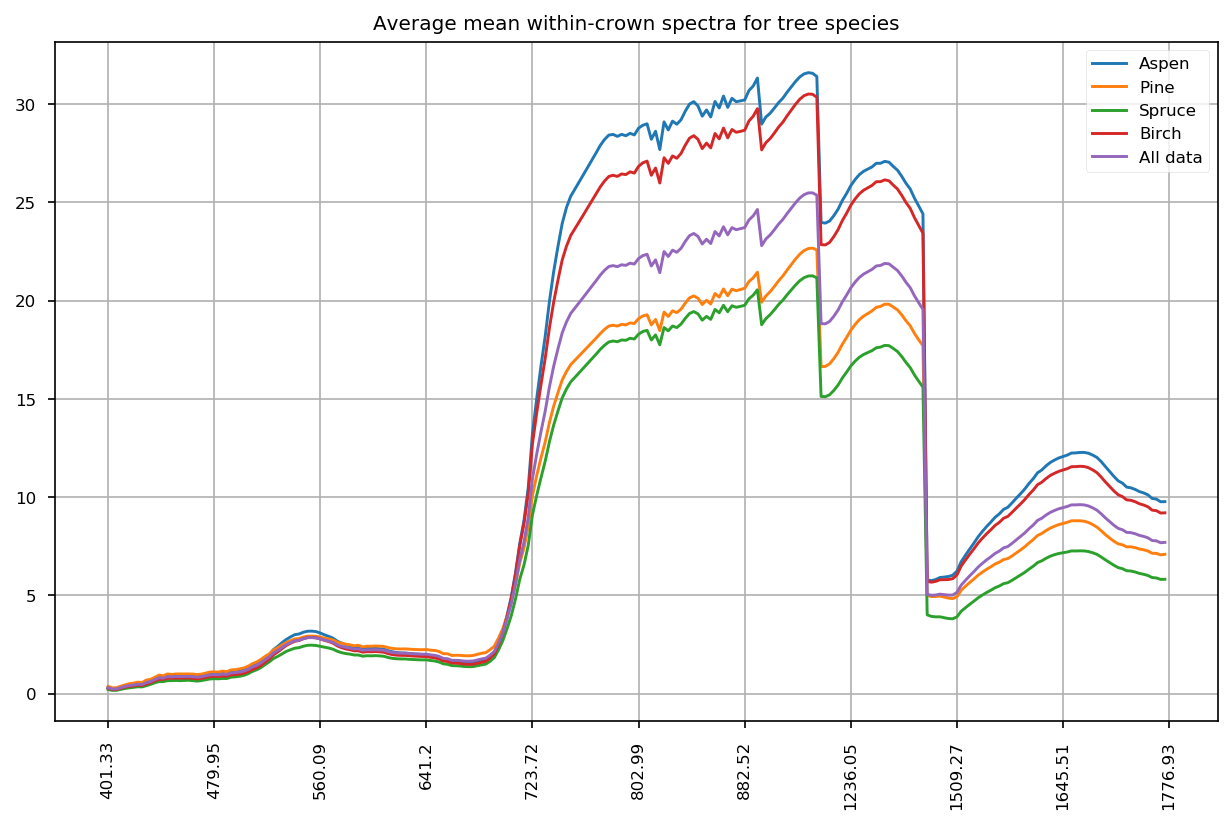

In [47]:
temp = train_X.copy()
temp = temp[temp.columns[:250]]
all_means = np.nanmean(temp.values, axis=0)
temp['label'] = train_y
aspen_means = np.nanmean(temp[temp.label == 1].values[:,:-1], axis=0)
birch_means = np.nanmean(temp[temp.label == 0].values[:,:-1], axis=0)
spruce_means = np.nanmean(temp[temp.label == 2].values[:,:-1], axis=0)
pine_means = np.nanmean(temp[temp.label == 3].values[:,:-1], axis=0)

plt.figure(figsize=(10,6), dpi=150)
#plt.axvline(x=154, c='y')

plt.plot(aspen_means)
plt.plot(pine_means)
plt.plot(spruce_means)
plt.plot(birch_means)
plt.plot(all_means)
sel_bws = atm_cor_bandwidths[bands]
labels = [round(sel_bws[i],2) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],2))

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='vertical')
plt.legend([#'Border between VNIR and SWIR sensors',
            f'Aspen', f'Pine', 
            f'Spruce', f'Birch',
            'All data'])
plt.title('Average mean within-crown spectra for tree species')
plt.grid()
plt.show()

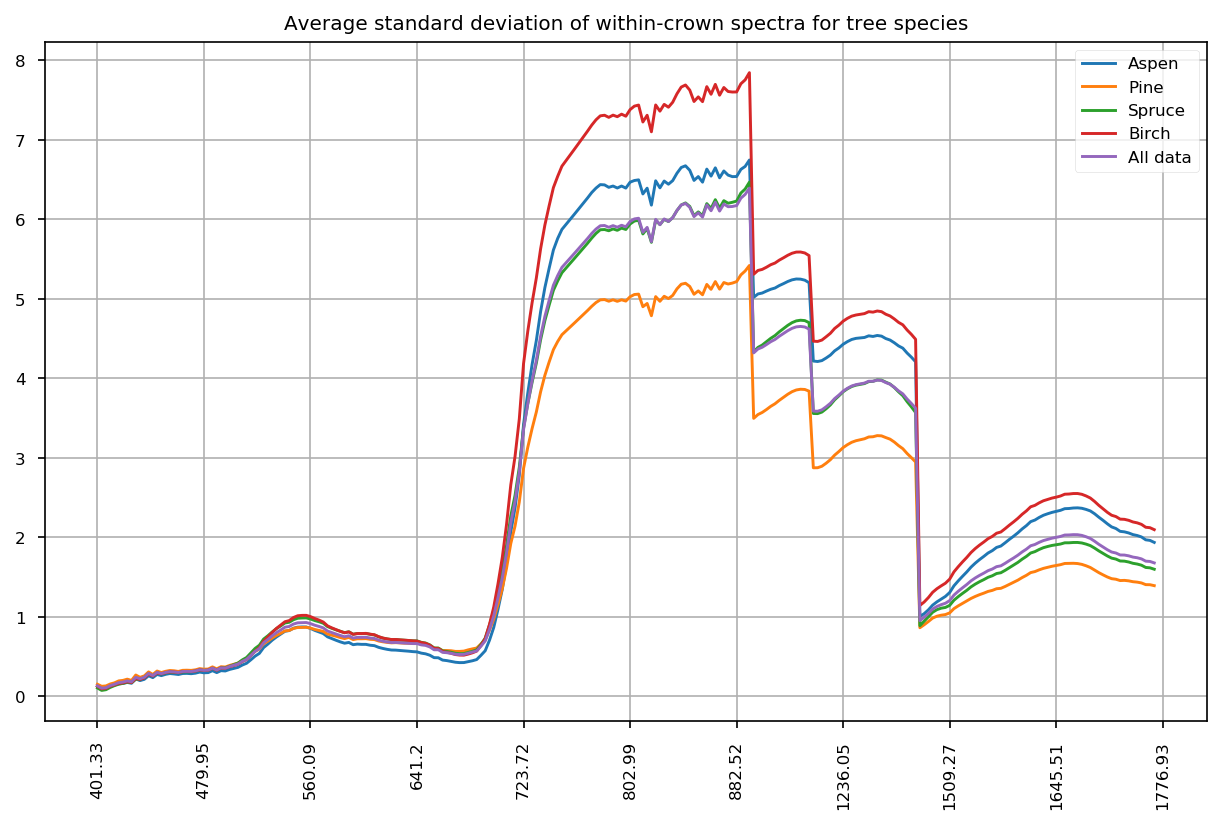

In [48]:
temp = train_X.copy()
temp = temp[temp.columns[250:-1]]
all_means = np.nanmean(temp.values, axis=0)
temp['label'] = train_y
aspen_means = np.nanmean(temp[temp.label == 1].values[:,:-1], axis=0)
birch_means = np.nanmean(temp[temp.label == 0].values[:,:-1], axis=0)
spruce_means = np.nanmean(temp[temp.label == 2].values[:,:-1], axis=0)
pine_means = np.nanmean(temp[temp.label == 3].values[:,:-1], axis=0)

plt.figure(figsize=(10,6), dpi=150)
#plt.axvline(x=154, c='y')

plt.plot(aspen_means)
plt.plot(pine_means)
plt.plot(spruce_means)
plt.plot(birch_means)
plt.plot(all_means)
sel_bws = atm_cor_bandwidths[bands]
labels = [round(sel_bws[i],2) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],2))

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='vertical')
plt.legend([#'Border between VNIR and SWIR sensors',
            f'Aspen', f'Pine', 
            f'Spruce', f'Birch',
            'All data'])
plt.title('Average standard deviation of within-crown spectra for tree species')
plt.grid()
plt.show()

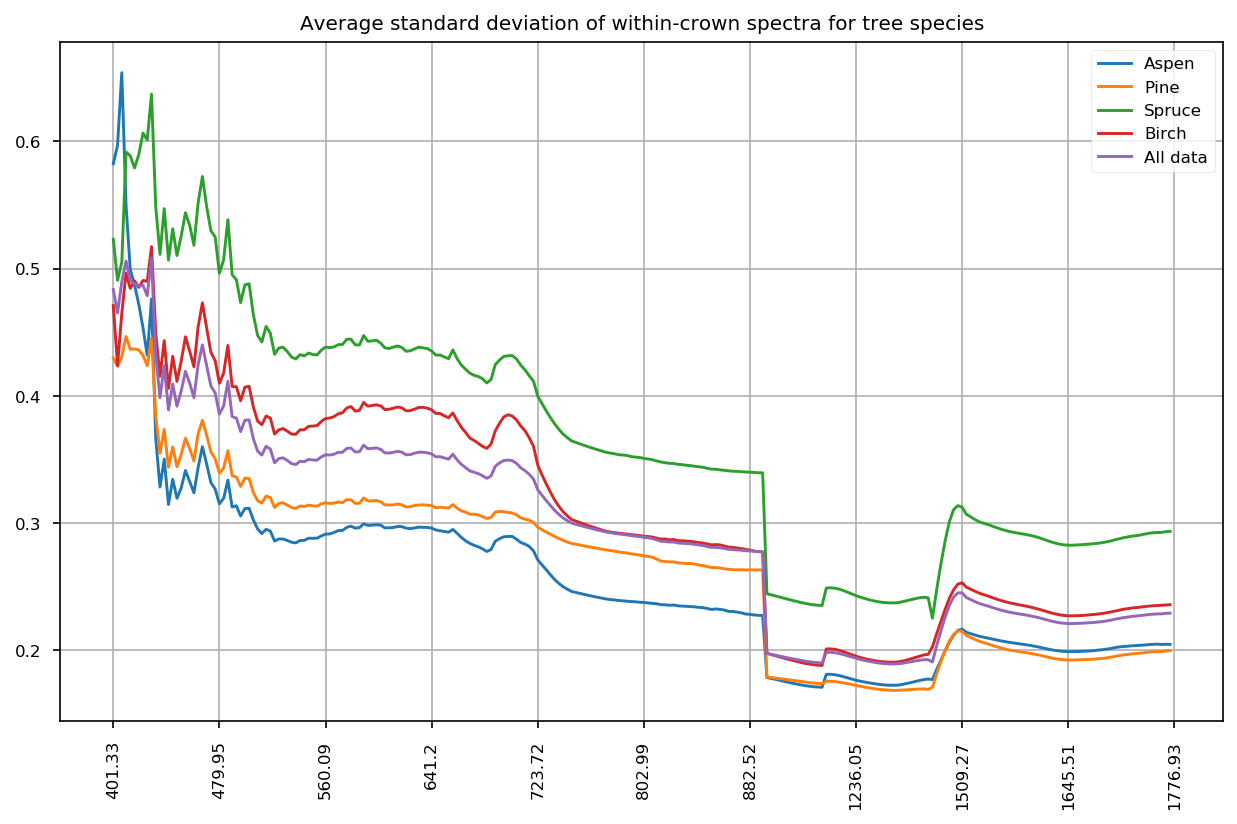

In [50]:
temp = train_X.copy()
temp_std = temp[temp.columns[250:]]
temp_mean = temp[temp.columns[:250]]
temp = temp_std.values/temp_mean
all_means = np.nanmean(temp.values, axis=0)
temp['label'] = train_y
aspen_means = np.nanmean(temp[temp.label == 1].values[:,:-1], axis=0)
birch_means = np.nanmean(temp[temp.label == 0].values[:,:-1], axis=0)
spruce_means = np.nanmean(temp[temp.label == 2].values[:,:-1], axis=0)
pine_means = np.nanmean(temp[temp.label == 3].values[:,:-1], axis=0)

plt.figure(figsize=(10,6), dpi=150)
#plt.axvline(x=154, c='y')

plt.plot(aspen_means)
plt.plot(pine_means)
plt.plot(spruce_means)
plt.plot(birch_means)
plt.plot(all_means)
sel_bws = atm_cor_bandwidths[bands]
labels = [round(sel_bws[i],2) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],2))

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='vertical')
plt.legend([#'Border between VNIR and SWIR sensors',
            f'Aspen', f'Pine', 
            f'Spruce', f'Birch',
            'All data'])
plt.title('Average standard deviation of within-crown spectra for tree species')
plt.grid()
plt.show()

Fit StandardScaler to standardize data

In [51]:
scaler = StandardScaler()
scaler.fit(train_X)

StandardScaler(copy=True, with_mean=True, with_std=True)

# KNN

Set parameter grid for cross-validation

In [38]:
knn = KNN()
np.random.seed(seed)
knn_paramgrid = {'n_neighbors': list(range(3,10)),
                 'weights': ['uniform', 'distance'],
                 'p': [1,2]}
knn_search = RandomizedSearchCV(knn, knn_paramgrid, cv=5, n_iter=15, n_jobs=-1, verbose=2, random_state=seed)

Do random search and best hyperparameters

In [39]:
knn_search.fit(scaler.transform(train_X), train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.0s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=15, n_jobs=-1,
                   param_distributions={'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=12, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [40]:
report(knn_search.cv_results_)

Model with rank: 1
Mean validation score: 0.685 (std: 0.040)
Parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 8}

Model with rank: 2
Mean validation score: 0.684 (std: 0.048)
Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 6}

Model with rank: 3
Mean validation score: 0.684 (std: 0.039)
Parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 9}



Fit best hyperparameters

In [41]:
best_knn = knn_search.best_estimator_

Check results and confusion matrix

In [42]:
knn_preds = best_knn.predict(scaler.transform(test_X))

In [43]:
print(f'OA: {accuracy_score(test_y, knn_preds):.2f}, BA: {balanced_accuracy_score(test_y, knn_preds):.2f}, Kappa: {cohen_kappa_score(test_y, knn_preds):.2f}')
print(classification_report(test_y, knn_preds, target_names=species))


OA: 0.69, BA: 0.66, Kappa: 0.56
                precision    recall  f1-score   support

         Birch       0.47      0.73      0.57        71
European aspen       0.73      0.45      0.56        84
 Norway spruce       0.79      0.68      0.73       210
    Scots pine       0.70      0.79      0.74       171

      accuracy                           0.69       536
     macro avg       0.67      0.66      0.65       536
  weighted avg       0.71      0.69      0.69       536



In [44]:
from sklearn.metrics import plot_confusion_matrix

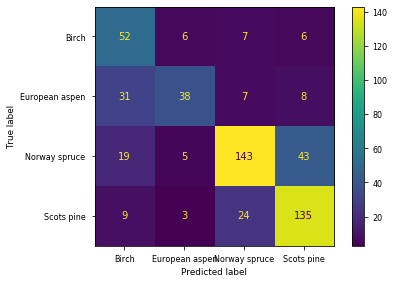

In [45]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.style.use('seaborn-paper')
plot_confusion_matrix(best_knn, scaler.transform(test_X), test_y, display_labels=species, values_format='d')

# Random forest scaled

In [46]:
rf = RandomForestClassifier(oob_score=True)
np.random.seed(seed)
rf_paramgrid = {'n_estimators': [100, 200, 500],
                'criterion': ['gini', 'entropy'],
                'min_samples_split': list(range(2,10)),
                'max_features': ['auto', 'log2', None],
                'class_weight': ['balanced', None],
                 'random_state': [seed]}
rf_search = RandomizedSearchCV(rf, rf_paramgrid, cv=5, n_iter=15, n_jobs=-1, verbose=2, random_state=seed)

We don't need to normalize data when using random forest

In [47]:
rf_search.fit(scaler.transform(train_X), train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 11.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [48]:
report(rf_search.cv_results_)

Model with rank: 1
Mean validation score: 0.722 (std: 0.036)
Parameters: {'random_state': 12, 'n_estimators': 500, 'min_samples_split': 6, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': 'balanced'}

Model with rank: 2
Mean validation score: 0.717 (std: 0.031)
Parameters: {'random_state': 12, 'n_estimators': 100, 'min_samples_split': 9, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': None}

Model with rank: 3
Mean validation score: 0.716 (std: 0.033)
Parameters: {'random_state': 12, 'n_estimators': 200, 'min_samples_split': 9, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': 'balanced'}



Select best hyperparameters

In [49]:
best_rf = rf_search.best_estimator_

In [50]:
best_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=12, verbose=0,
                       warm_start=False)

Check results and confusion matrix

In [51]:
rf_preds = best_rf.predict(scaler.transform(test_X))

In [52]:
print(f'OA: {accuracy_score(test_y, rf_preds):.2f}, BA: {balanced_accuracy_score(test_y, rf_preds):.2f}, Kappa: {cohen_kappa_score(test_y, rf_preds):.2f}')
print(classification_report(test_y, rf_preds, target_names=species))


OA: 0.69, BA: 0.65, Kappa: 0.57
                precision    recall  f1-score   support

         Birch       0.42      0.73      0.54        71
European aspen       0.75      0.32      0.45        84
 Norway spruce       0.79      0.74      0.76       210
    Scots pine       0.77      0.80      0.78       171

      accuracy                           0.69       536
     macro avg       0.68      0.65      0.63       536
  weighted avg       0.73      0.69      0.69       536



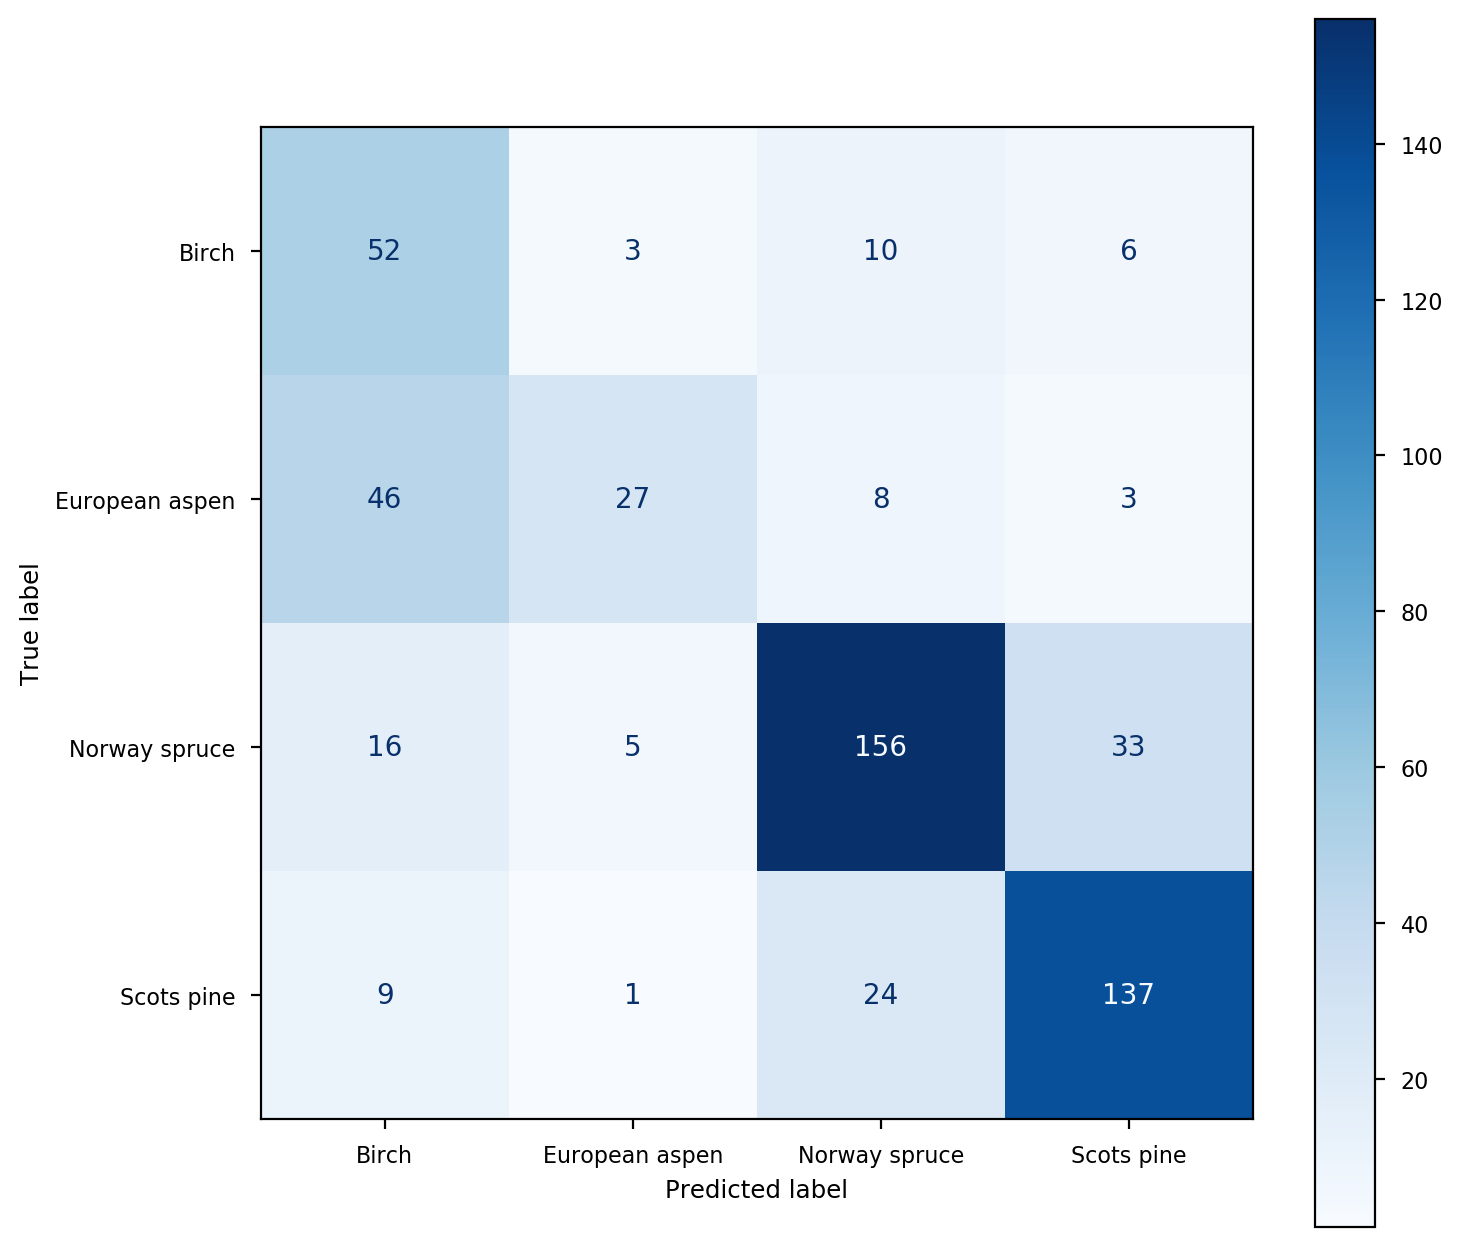

In [54]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 200
plot_confusion_matrix(best_rf,scaler.transform(test_X), test_y, display_labels=species, values_format='d', cmap='Blues')

# Random forest unscaled

In [55]:
rf = RandomForestClassifier(oob_score=True)
np.random.seed(seed)
rf_paramgrid = {'n_estimators': [100, 200, 500],
                'criterion': ['gini', 'entropy'],
                'min_samples_split': list(range(2,10)),
                'max_features': ['auto', 'log2', None],
                'class_weight': ['balanced', None],
                 'random_state': [seed]}
rf_search = RandomizedSearchCV(rf, rf_paramgrid, cv=5, n_iter=15, n_jobs=-1, verbose=2, random_state=seed)

We don't need to normalize data when using random forest

In [56]:
rf_search.fit(train_X, train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 11.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [63]:
report(rf_search.cv_results_)

Model with rank: 1
Mean validation score: 0.722 (std: 0.036)
Parameters: {'random_state': 12, 'n_estimators': 500, 'min_samples_split': 6, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': 'balanced'}

Model with rank: 2
Mean validation score: 0.717 (std: 0.031)
Parameters: {'random_state': 12, 'n_estimators': 100, 'min_samples_split': 9, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': None}

Model with rank: 3
Mean validation score: 0.716 (std: 0.033)
Parameters: {'random_state': 12, 'n_estimators': 200, 'min_samples_split': 9, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': 'balanced'}



Select best hyperparameters

In [64]:
best_rf = rf_search.best_estimator_

In [65]:
best_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=12, verbose=0,
                       warm_start=False)

Check results and confusion matrix

In [66]:
rf_preds = best_rf.predict(test_X)

In [67]:
print(f'OA: {accuracy_score(test_y, rf_preds):.2f}, BA: {balanced_accuracy_score(test_y, rf_preds):.2f}, Kappa: {cohen_kappa_score(test_y, rf_preds):.2f}')
print(classification_report(test_y, rf_preds, target_names=species))


OA: 0.69, BA: 0.65, Kappa: 0.57
                precision    recall  f1-score   support

         Birch       0.42      0.73      0.54        71
European aspen       0.75      0.32      0.45        84
 Norway spruce       0.79      0.74      0.76       210
    Scots pine       0.77      0.80      0.78       171

      accuracy                           0.69       536
     macro avg       0.68      0.65      0.63       536
  weighted avg       0.73      0.69      0.69       536



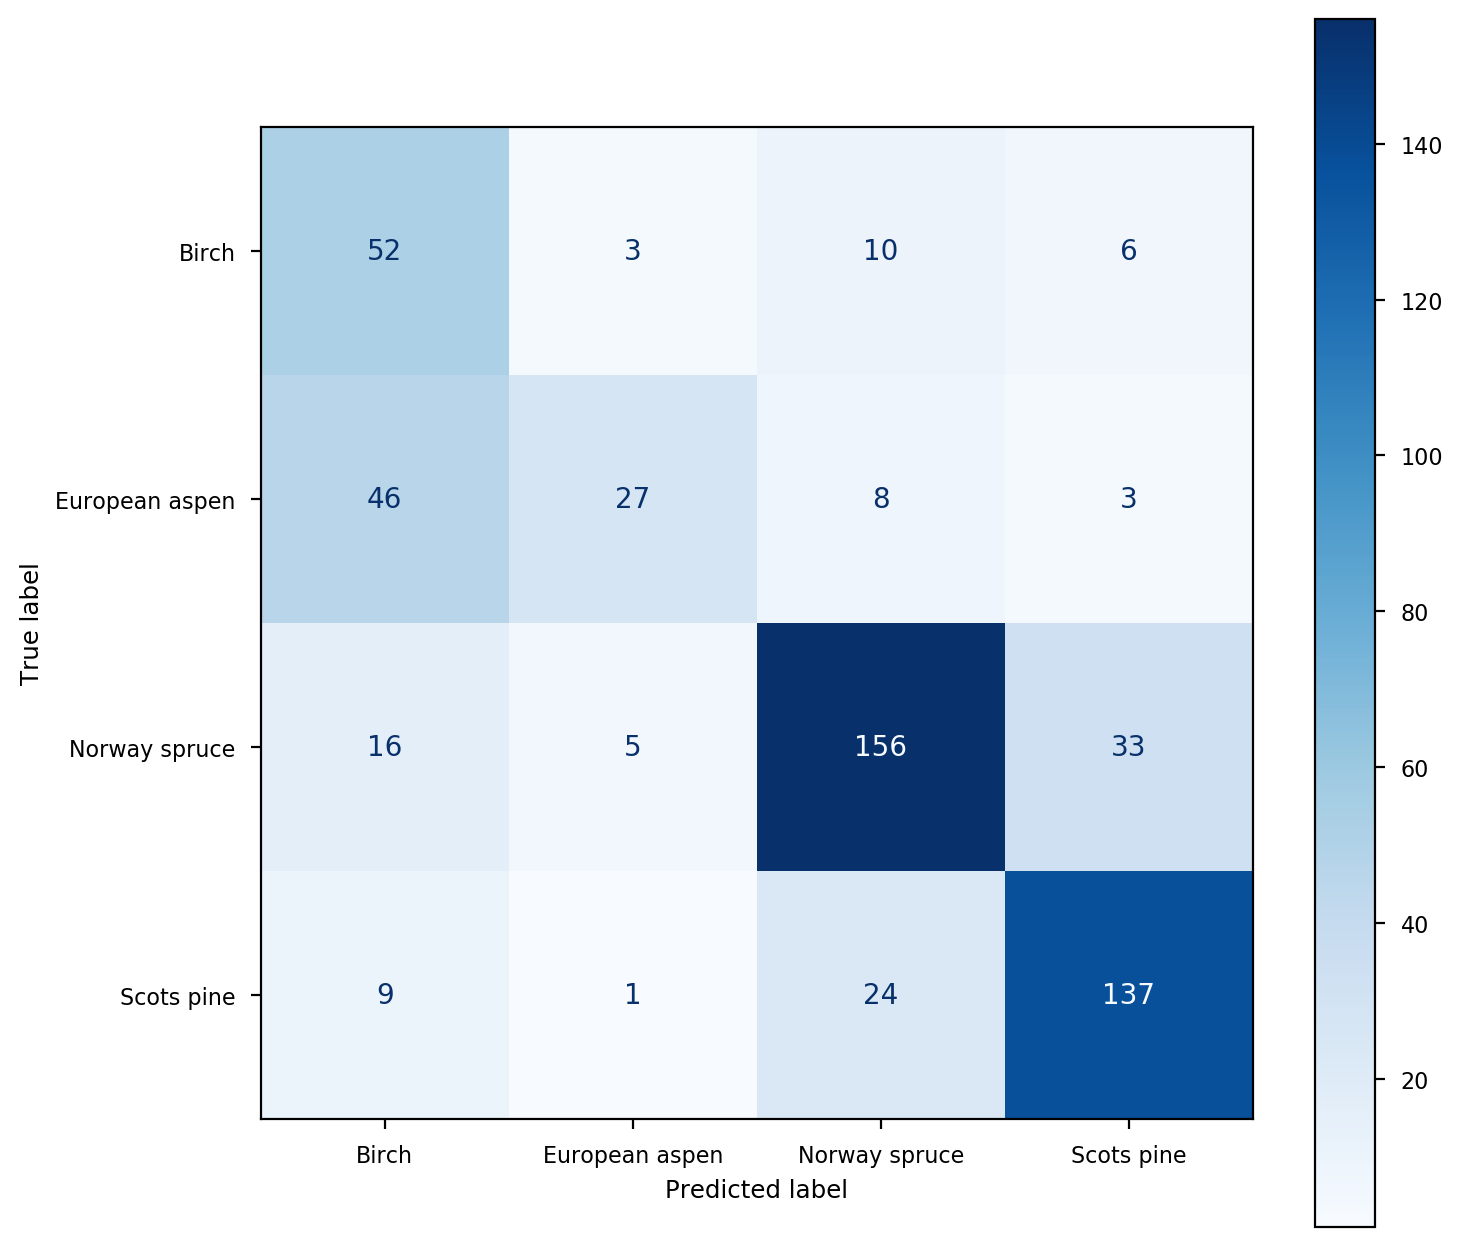

In [68]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 200
plot_confusion_matrix(best_rf,test_X, test_y, display_labels=species, values_format='d', cmap='Blues')

# SVM with linear kernel

In [112]:
lin_svm = LinearSVC()
np.random.seed(seed)
lin_svm_paramgrid = {'penalty': ['l2'], 
                     'loss': ['hinge', 'squared_hinge'],
                     'dual': [True], 
                     'C': stats.uniform(1,10),
                     'fit_intercept': [False],
                     'class_weight': [None, 'balanced'],
                 'random_state': [seed]}
lin_svm_search = RandomizedSearchCV(lin_svm, lin_svm_paramgrid, cv=5, n_iter=15, n_jobs=-1, verbose=2, random_state=seed)

In [113]:
lin_svm_search.fit(scaler.transform(train_X), train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                       fit_intercept=True, intercept_scaling=1,
                                       loss='squared_hinge', max_iter=1000,
                                       multi_class='ovr', penalty='l2',
                                       random_state=None, tol=0.0001,
                                       verbose=0),
                   iid='deprecated', n_iter=15, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f83384748d0>,
                                        'class_weight': [None, 'balanced'],
                                        'dual': [True],
                                        'fit_intercept': [False],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'penalty': ['l2'],
                        

In [114]:
report(lin_svm_search.cv_results_)

Model with rank: 1
Mean validation score: 0.828 (std: 0.023)
Parameters: {'C': 3.895867835305536, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 12}

Model with rank: 2
Mean validation score: 0.828 (std: 0.022)
Parameters: {'C': 2.3521017836911686, 'class_weight': None, 'dual': True, 'fit_intercept': False, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 12}

Model with rank: 3
Mean validation score: 0.808 (std: 0.054)
Parameters: {'C': 1.0225923351851354, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 12}



In [115]:
best_lin_svm = lin_svm_search.best_estimator_

Check results and confusion matrix

In [116]:
%timeit lin_svm_preds = best_lin_svm.predict(scaler.transform(test_X))

2.47 ms ± 3.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [117]:
lin_svm_preds = best_lin_svm.predict(scaler.transform(test_X))

In [118]:
print(f'OA: {accuracy_score(test_y, lin_svm_preds):.4f}, BA: {balanced_accuracy_score(test_y, lin_svm_preds):.4f}, Kappa: {cohen_kappa_score(test_y, lin_svm_preds):.4f}')
print(classification_report(test_y, lin_svm_preds, target_names=species))


OA: 0.8284, BA: 0.8283, Kappa: 0.7563
              precision    recall  f1-score   support

       Birch       0.69      0.75      0.72        71
       Aspen       0.90      0.93      0.91        84
      Spruce       0.80      0.84      0.82       210
        Pine       0.89      0.80      0.84       171

    accuracy                           0.83       536
   macro avg       0.82      0.83      0.82       536
weighted avg       0.83      0.83      0.83       536



In [49]:
plt.rcParams["figure.figsize"] = (8, 8)
plot_confusion_matrix(best_lin_svm, scaler.transform(test_X), test_y, display_labels=species, values_format='d', cmap='Blues')

NameError: name 'plot_confusion_matrix' is not defined

## Feature importances for SVM

In [119]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [120]:
species = ['Birch', 'Aspen', 'Spruce', 'Pine']

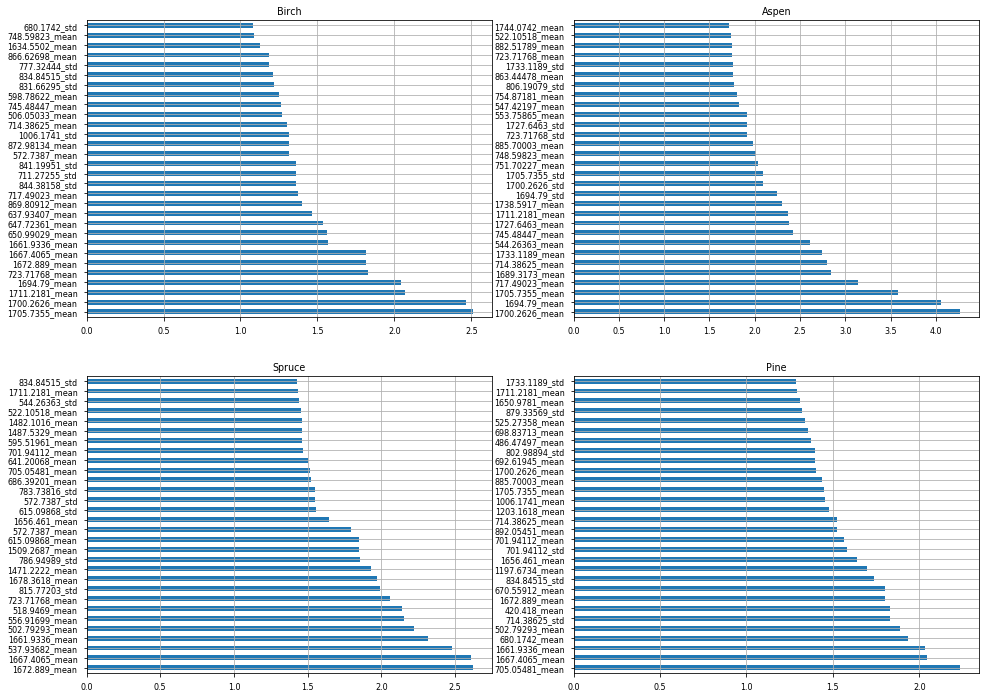

In [124]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    pd.Series(abs(best_lin_svm.coef_[i]), index=train_X.columns).nlargest(30).plot(kind='barh', title=species[i], ax=ax)
    ax.grid(True)
fig.savefig('svm_abs_importances.jpeg', dpi=300, bbox_inches='tight')

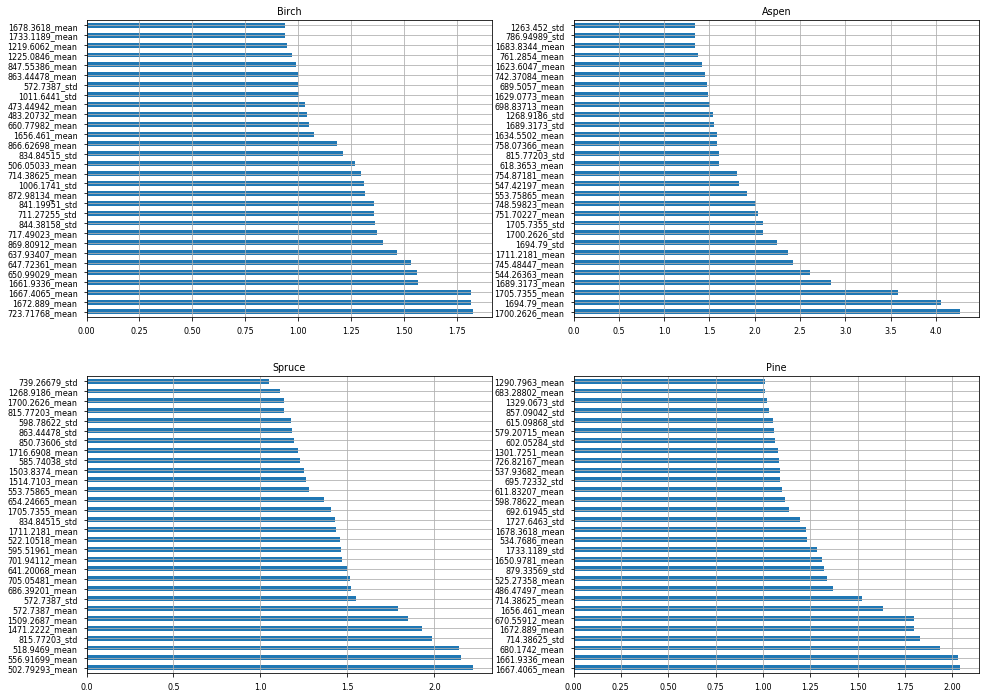

In [125]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    pd.Series(best_lin_svm.coef_[i], index=train_X.columns).nlargest(30).plot(kind='barh', title=species[i], ax=ax)
    ax.grid(True)
fig.savefig('svm_importances_large.jpeg', dpi=300, bbox_inches='tight')

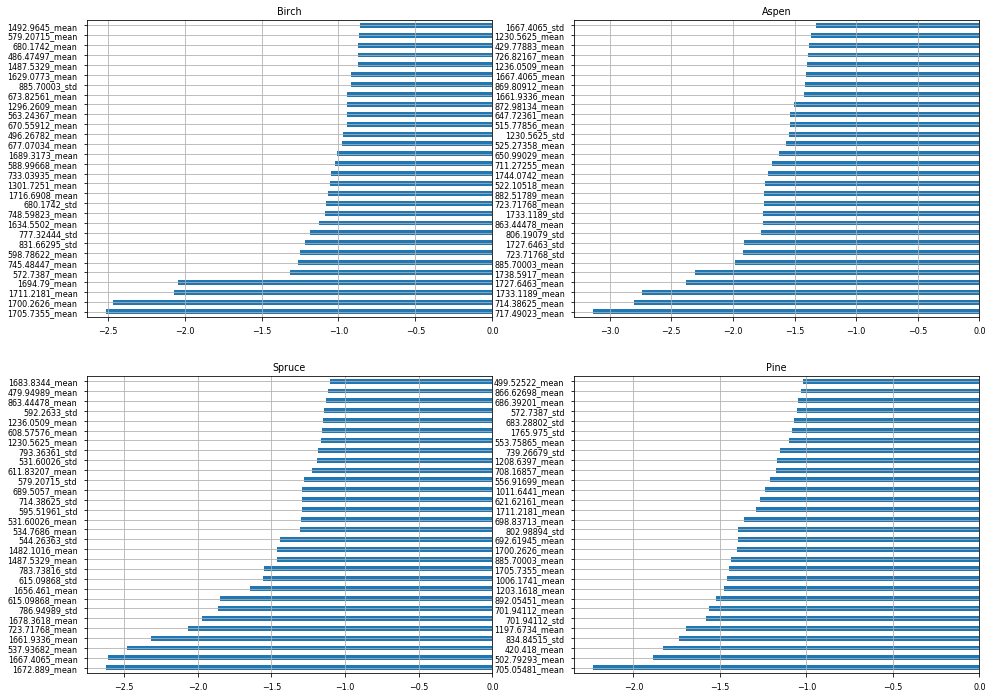

In [126]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    pd.Series(best_lin_svm.coef_[i], index=train_X.columns).nsmallest(30).plot(kind='barh', title=species[i], ax=ax)
    ax.grid(True)
fig.savefig('svm_importances_smallest.jpeg', dpi=300, bbox_inches='tight')

# SVM with radial basis function kernel

In [61]:
rbf_svm = SVC(kernel='rbf')
np.random.seed(seed)
rbf_svm_paramgrid = {'C': stats.uniform(1,10),
                     'gamma': ['auto', 'scale'], 
                     'class_weight': [None, 'balanced'],
                 'random_state': [seed]}
rbf_svm_search = RandomizedSearchCV(rbf_svm, rbf_svm_paramgrid, cv=5, n_iter=15, n_jobs=-1, verbose=2, random_state=seed)

In [62]:
rbf_svm_search.fit(scaler.transform(train_X), train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   17.5s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=15, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f54bd3697d0>,
                                        'class_weight': [None, 'balanced'],
                                        'gamma': ['auto', 'scale'],
                                        'random_state': [12]},
                   pre_dispatch='2*n_jobs', random_state=12, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [63]:
report(rbf_svm_search.cv_results_)

Model with rank: 1
Mean validation score: 0.784 (std: 0.029)
Parameters: {'C': 8.681341540644222, 'class_weight': None, 'gamma': 'auto', 'random_state': 12}

Model with rank: 2
Mean validation score: 0.782 (std: 0.028)
Parameters: {'C': 10.569493362751167, 'class_weight': None, 'gamma': 'auto', 'random_state': 12}

Model with rank: 3
Mean validation score: 0.779 (std: 0.035)
Parameters: {'C': 5.712297782500141, 'class_weight': None, 'gamma': 'scale', 'random_state': 12}



Fit best hyperparameters

In [64]:
best_rbf_svm = rbf_svm_search.best_estimator_

Check results and confusion matrix

In [65]:
rbf_svm_preds = best_rbf_svm.predict(scaler.transform(test_X))

In [66]:
print(f'OA: {accuracy_score(test_y, rbf_svm_preds):.2f}, BA: {balanced_accuracy_score(test_y, rbf_svm_preds):.2f}, Kappa: {cohen_kappa_score(test_y, rbf_svm_preds):.2f}')
print(classification_report(test_y, rbf_svm_preds, target_names=species))


OA: 0.76, BA: 0.73, Kappa: 0.67
                precision    recall  f1-score   support

         Birch       0.47      0.76      0.58        71
European aspen       0.92      0.52      0.67        84
 Norway spruce       0.85      0.76      0.80       210
    Scots pine       0.82      0.89      0.85       171

      accuracy                           0.76       536
     macro avg       0.76      0.73      0.73       536
  weighted avg       0.80      0.76      0.77       536



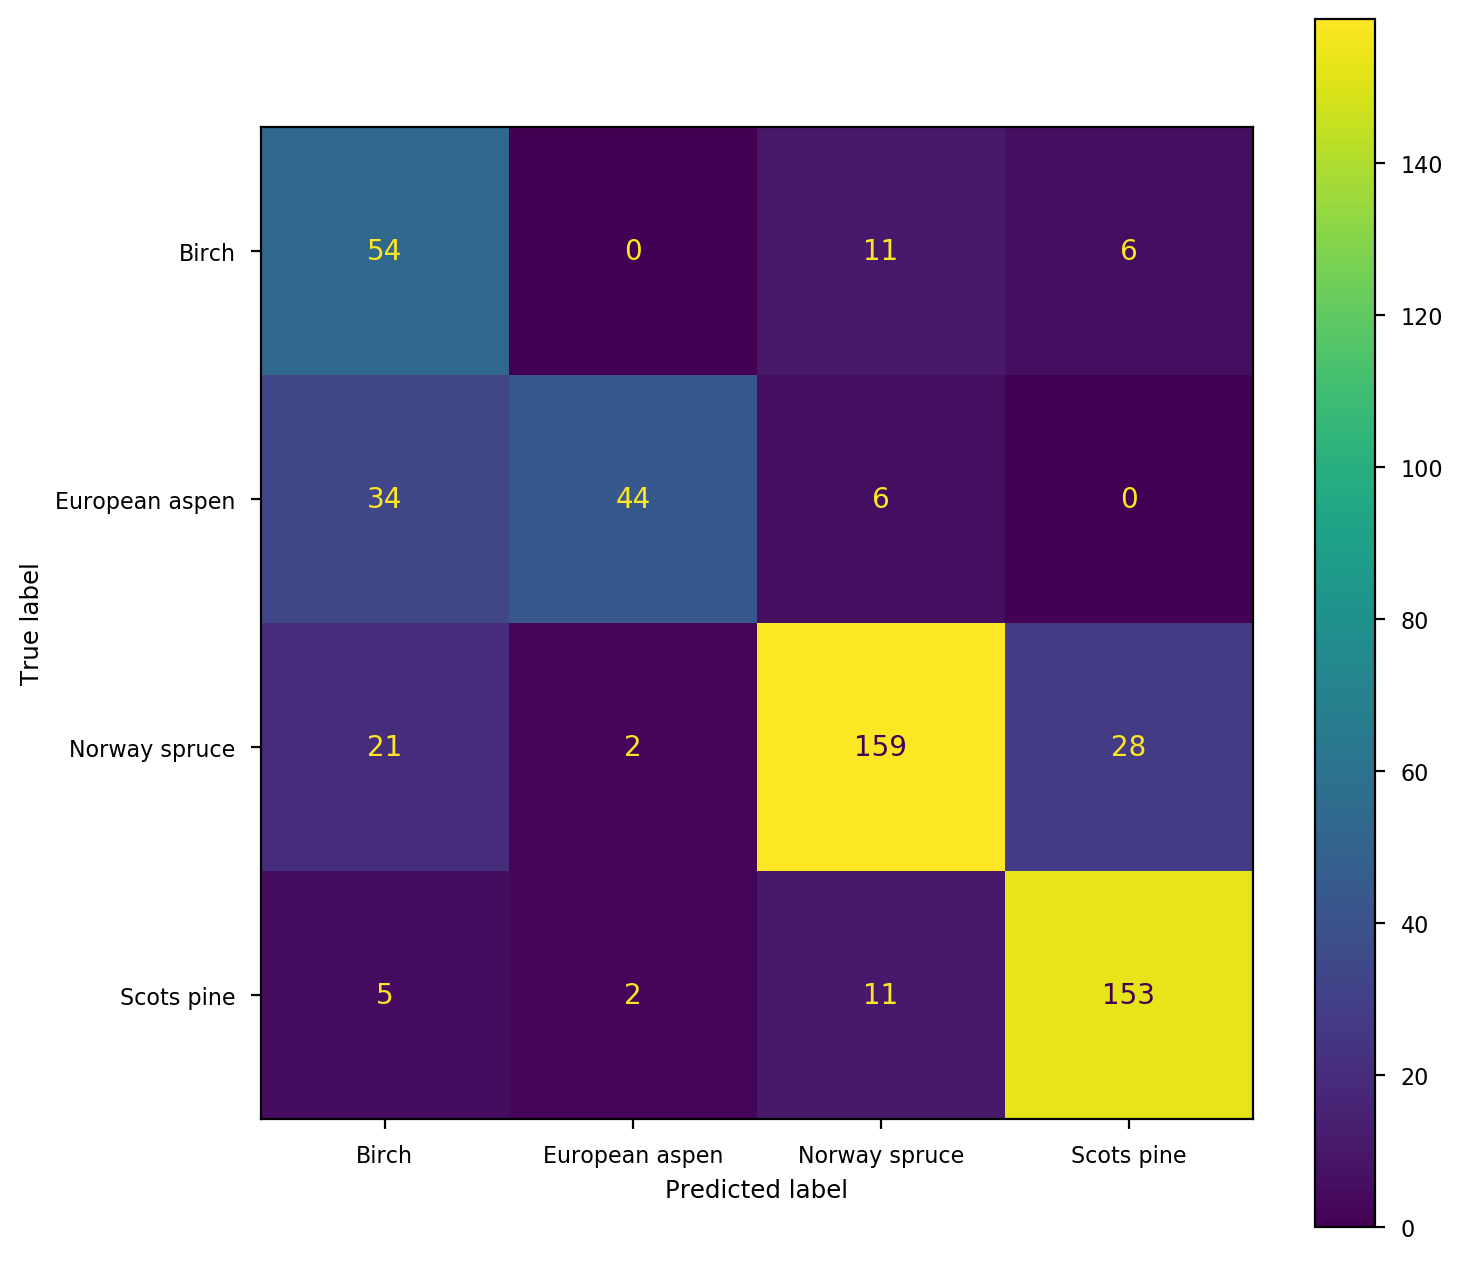

In [67]:
plt.rcParams["figure.figsize"] = (8, 8)
plot_confusion_matrix(best_rbf_svm, scaler.transform(test_X), test_y, display_labels=species, values_format='d')

# LightGBM

In [68]:
lgb_clf = lgb.LGBMClassifier(metric='multi_logloss', learning_rate=0.1, boosting_type='gbdt', objective='multiclass',
                             n_estimators=200)
np.random.seed(seed)
lgb_paramgrid = {
                'num_leaves': [63, 127, 255, 511],
                'colsample_bytree' : [0.5, 0.6, 0.7, 0.8],
                'subsample' : [0.5, 0.6, 0.7, 0.8],
                'class_weight': ['balanced', None],
                 'random_state': [seed]}
lgb_search = RandomizedSearchCV(lgb_clf, lgb_paramgrid, cv=5, n_iter=15, n_jobs=-1, verbose=2, random_state=seed)

In [69]:
lgb_search.fit(train_X, train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 10.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='multi_logloss',
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=200, n_jobs=-1,
                                            num_leaves=31,
                                            objective='multiclass',
                                            random_state=None, re...
                                            subsample_for_bin=200000,
            

In [70]:
report(lgb_search.cv_results_)

Model with rank: 1
Mean validation score: 0.739 (std: 0.030)
Parameters: {'subsample': 0.8, 'random_state': 12, 'num_leaves': 255, 'colsample_bytree': 0.5, 'class_weight': 'balanced'}

Model with rank: 1
Mean validation score: 0.739 (std: 0.030)
Parameters: {'subsample': 0.8, 'random_state': 12, 'num_leaves': 511, 'colsample_bytree': 0.5, 'class_weight': 'balanced'}

Model with rank: 1
Mean validation score: 0.739 (std: 0.030)
Parameters: {'subsample': 0.5, 'random_state': 12, 'num_leaves': 255, 'colsample_bytree': 0.5, 'class_weight': 'balanced'}



In [71]:
best_lgb = lgb_search.best_estimator_

In [72]:
best_params = best_lgb.get_params()
best_params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.5,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 255,
 'objective': 'multiclass',
 'random_state': 12,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 0.8,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'multi_logloss'}

In [73]:
lgb_preds = best_lgb.predict(test_X)

In [74]:
print(f'OA: {accuracy_score(test_y, lgb_preds):.2f}, BA: {balanced_accuracy_score(test_y, lgb_preds):.2f}, Kappa: {cohen_kappa_score(test_y, lgb_preds):.2f}')
print(classification_report(test_y, lgb_preds, target_names=species))


OA: 0.70, BA: 0.65, Kappa: 0.57
                precision    recall  f1-score   support

         Birch       0.42      0.72      0.53        71
European aspen       0.78      0.33      0.47        84
 Norway spruce       0.79      0.74      0.77       210
    Scots pine       0.77      0.81      0.79       171

      accuracy                           0.70       536
     macro avg       0.69      0.65      0.64       536
  weighted avg       0.73      0.70      0.70       536



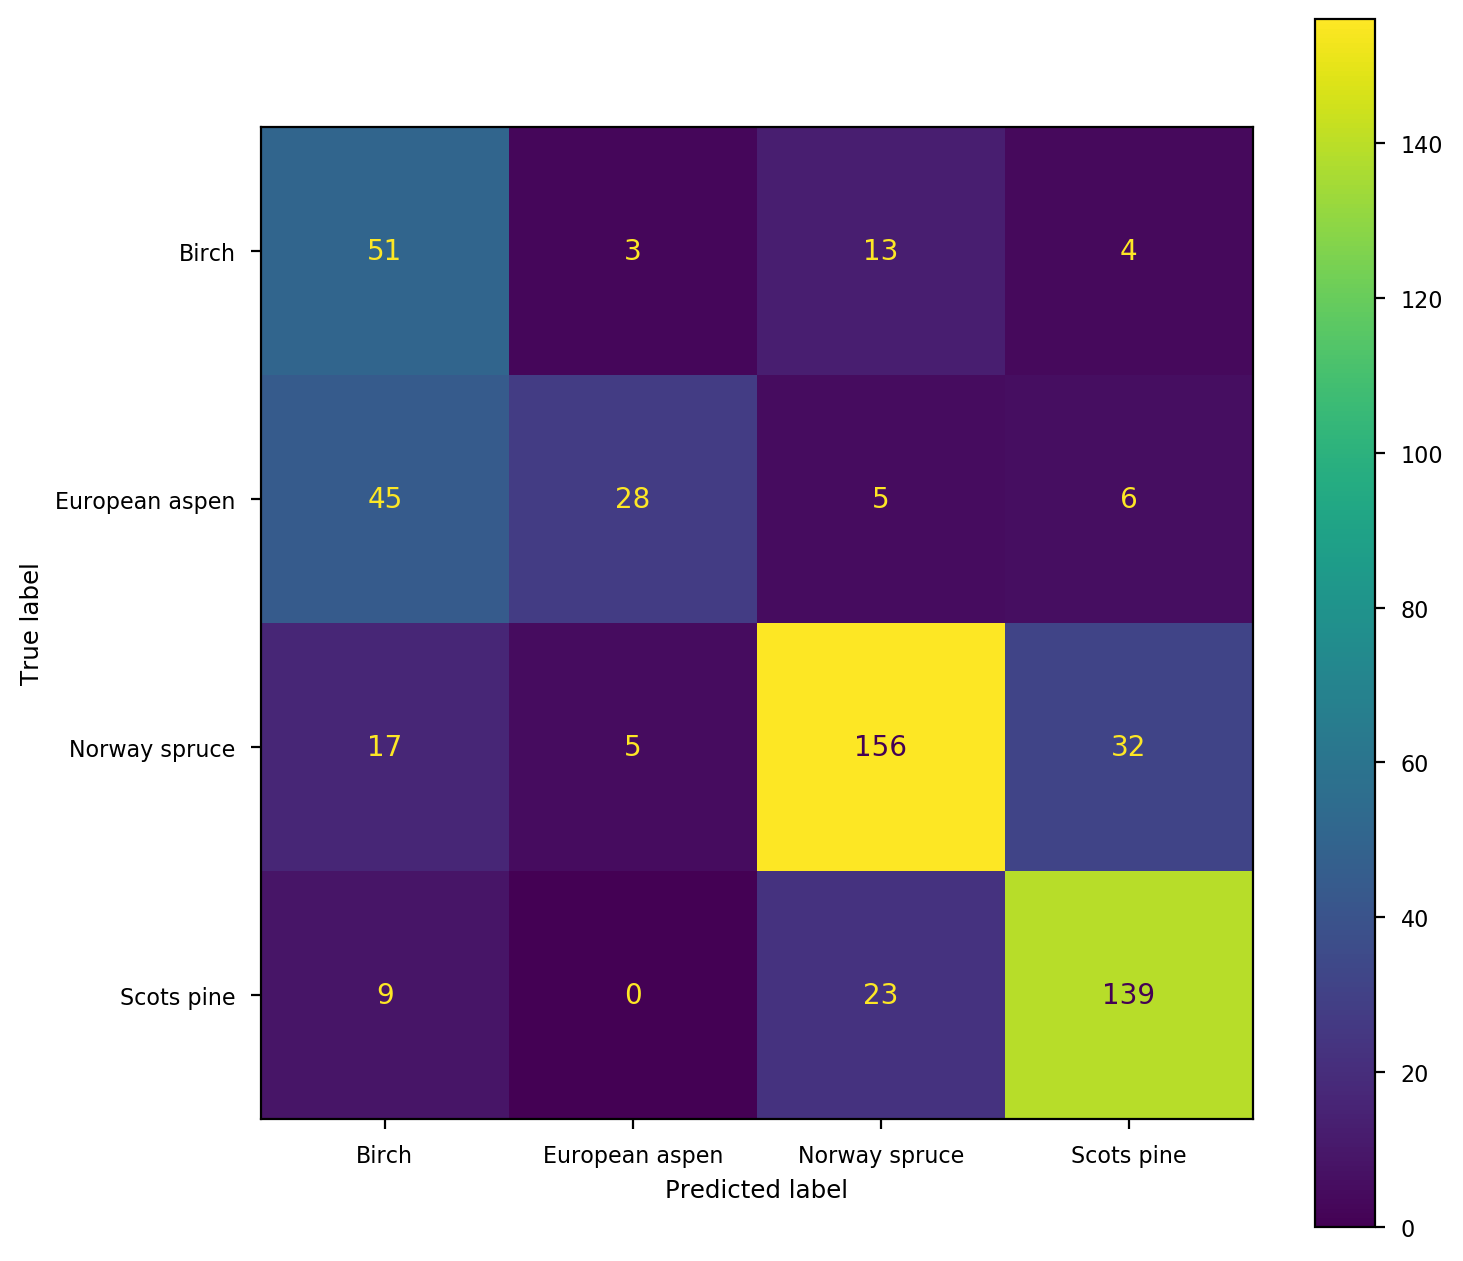

In [75]:
plt.rcParams["figure.figsize"] = (8, 8)
plot_confusion_matrix(best_lgb, test_X, test_y, display_labels=species, values_format='d')

# Feedforward neural network

Setting seed for PyTorch is not as trivial as one could hope

In [160]:
from fastai2.tabular.all import *
import torch
def reset_seed(seed=12):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [161]:
train_X.head()

,b_0_mean,b_1_mean,b_2_mean,b_3_mean,b_4_mean,b_5_mean,b_6_mean,b_7_mean,b_8_mean,b_9_mean,...,b_327_std,b_328_std,b_329_std,b_330_std,b_331_std,b_332_std,b_333_std,b_334_std,b_335_std,b_336_std
tree_id,,,,,,,,,,,,,,,,,,,,,
0,0.109819,0.096446,0.095341,0.089472,0.087947,0.095327,0.122993,0.160116,0.147312,0.193610,...,1.248214,1.245952,1.234387,1.219527,1.205533,1.191006,1.166004,1.160709,1.140368,1.138205
1,0.133815,0.097383,0.104588,0.127360,0.144204,0.170636,0.190832,0.229758,0.217332,0.281036,...,1.359302,1.355398,1.340705,1.324214,1.313646,1.293877,1.269123,1.259301,1.240102,1.241521
2,0.112297,0.102787,0.101746,0.154667,0.152399,0.199850,0.241073,0.236097,0.250573,0.352196,...,2.542379,2.539677,2.531070,2.508567,2.500095,2.478965,2.440411,2.426976,2.402467,2.400071
3,0.101147,0.090460,0.087916,0.083463,0.082869,0.116086,0.098487,0.116436,0.128344,0.158958,...,1.084058,1.077887,1.067085,1.056047,1.054034,1.040592,1.025087,1.016414,1.002287,0.998494
4,0.092329,0.088301,0.086088,0.075122,0.068139,0.083351,0.089880,0.089705,0.090433,0.122005,...,0.841157,0.829859,0.816812,0.804462,0.796781,0.785414,0.773311,0.766708,0.761533,0.762399


In [162]:
fastai_train = train_X.copy()
fastai_test = test_X.copy()

In [163]:
stats = [fastai_train.values.mean(axis=(0)), fastai_train.values.std(axis=(0))]

In [164]:
fastai_train['label'] = train_y
fastai_test['label'] = test_y
fastai_data = pd.concat((fastai_train, fastai_test))

In [166]:
fastai_data['label'] = fastai_data.apply(lambda row: species[int(row.label)], axis=1)

In [167]:
fastai_data.label.value_counts()

Scots pine        1089
Norway spruce      718
Birch              572
European aspen     448
Name: label, dtype: int64

In [187]:
procs = [Categorify, Normalize.from_stats(*np.array(stats))]
dls = TabularDataLoaders.from_df(fastai_data, path='.',  y_names=['label'], y_block=CategoryBlock, 
                                 valid_idx=listrange(2291, 2291+536),
                                )

In [198]:
from fastai2.callback.all import *

In [199]:
reset_seed(seed)
f1 = F1Score(average='macro')
precision = Precision(average='macro')
recall = Recall(average='macro')
kappa = CohenKappa()

learn = tabular_learner(dls, path=Path('../fastai_models/mlp'), model_dir='models',
                        metrics=[accuracy, precision, recall, f1, kappa],
                        opt_func=partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8),
                        cbs=[
#                            ShowGraphCallback(), 
#                            SaveModelCallback(monitor='f1_score'),
                            ])


In [200]:
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 500'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 500             1,000      True      
________________________________________________________________
BatchNorm1d          64 x 500             1,000      True      
________________________________________________________________
Linear               64 x 200             100,000    True      
________________________________________________________________
ReLU                 64 x 200             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
_______________________________________________

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.001737800776027143)

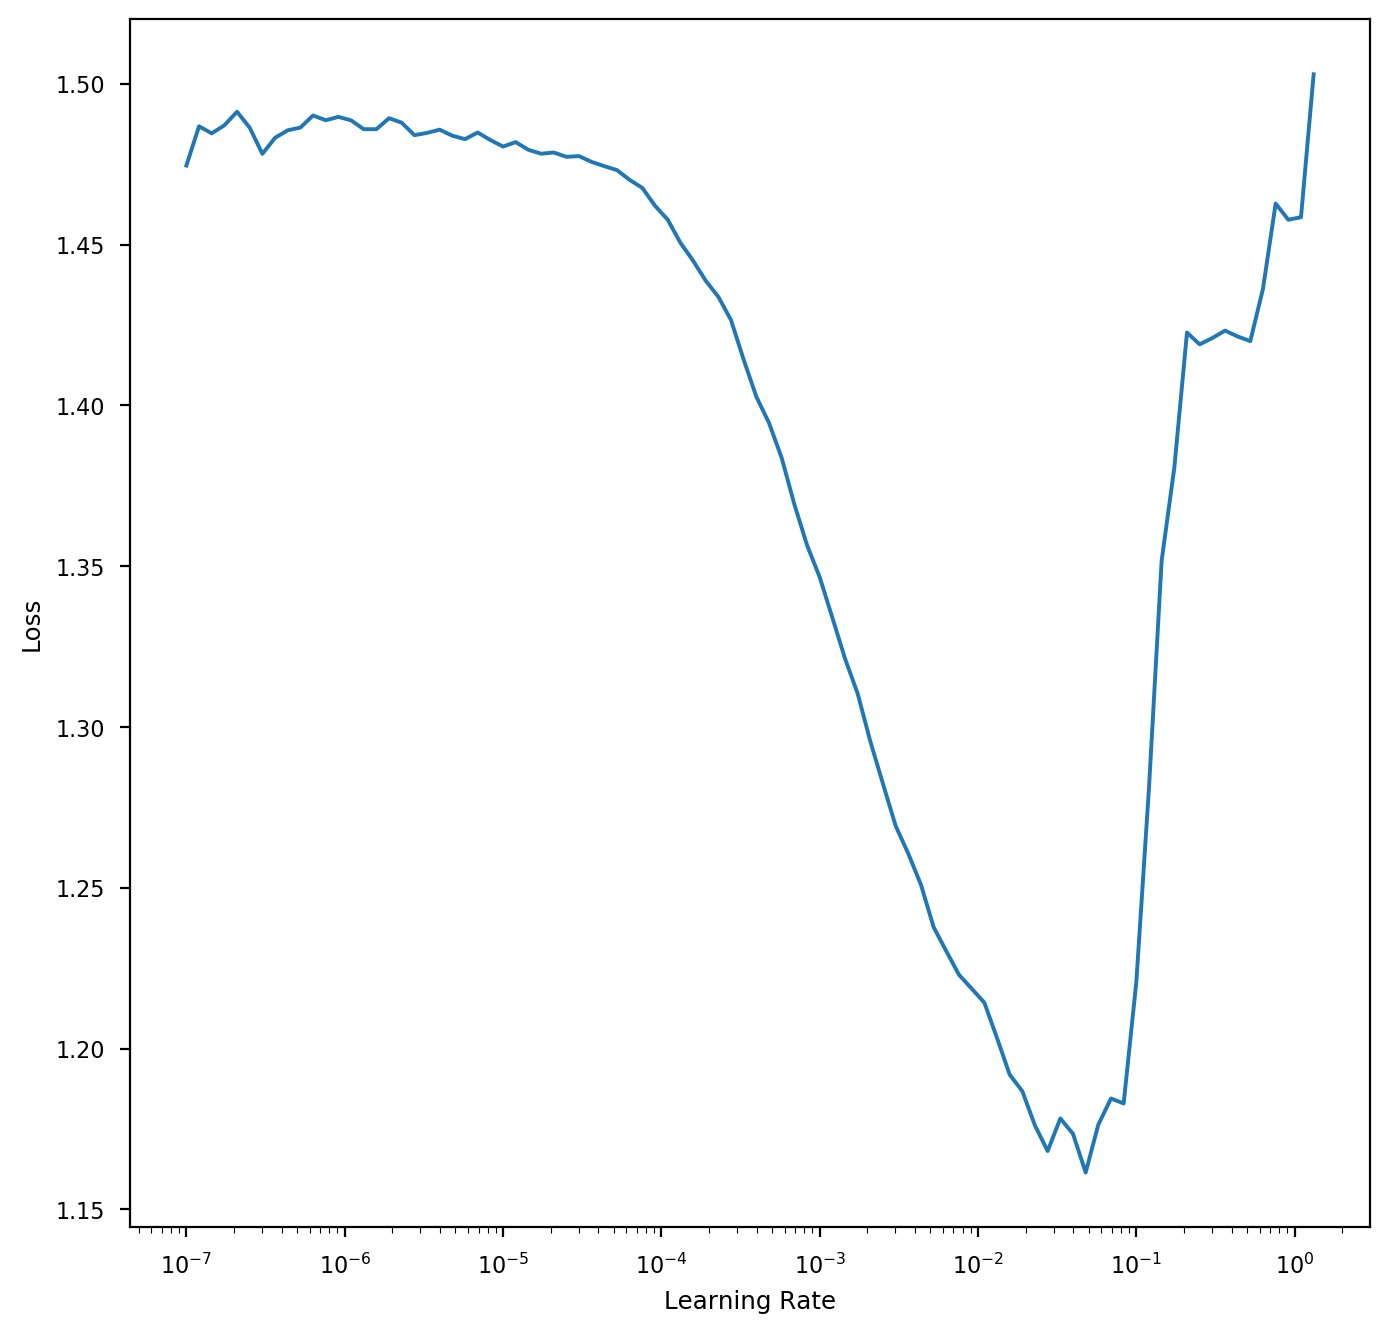

In [201]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,cohen_kappa_score,time
0,1.291893,1.205537,0.548507,0.617330,0.527935,0.492866,0.368057,00:00
1,1.145377,1.013306,0.639925,0.654104,0.611568,0.597382,0.488828,00:00
2,1.042063,0.914761,0.666045,0.655227,0.627525,0.618254,0.527304,00:00
3,0.953018,0.845996,0.684702,0.681614,0.653408,0.642290,0.555462,00:00
4,0.872842,0.777064,0.703358,0.729111,0.672576,0.664573,0.579174,00:00
5,0.814638,0.753630,0.716418,0.713921,0.680361,0.674925,0.597373,00:00
6,0.757262,0.759013,0.712687,0.739383,0.680704,0.665155,0.596886,00:00
7,0.722884,0.789053,0.708955,0.709197,0.675989,0.659856,0.594069,00:00
8,0.692074,0.729080,0.703358,0.713866,0.704824,0.692526,0.584802,00:00
9,0.676355,0.700927,0.753731,0.740739,0.727616,0.719211,0.653333,00:00


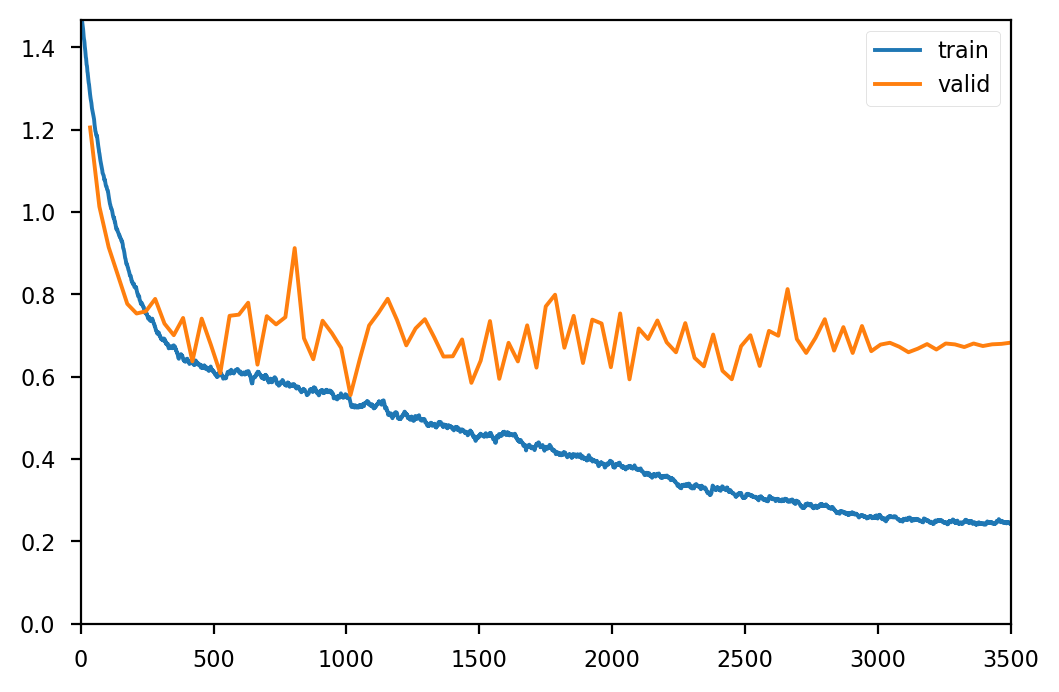

In [202]:
learn.fit_one_cycle(100, #lr_max=1.0E-3, 
                  cbs=[
                     ShowGraphCallback(), 
                     SaveModelCallback(monitor='f1_score')])

In [204]:
learn.validate()

(#6) [0.5554401874542236,0.8190298676490784,0.8069658268508842,0.8092700942497087,0.8068667032281399,0.7432772735801543]

In [205]:
interp = ClassificationInterpretation.from_learner(learn)

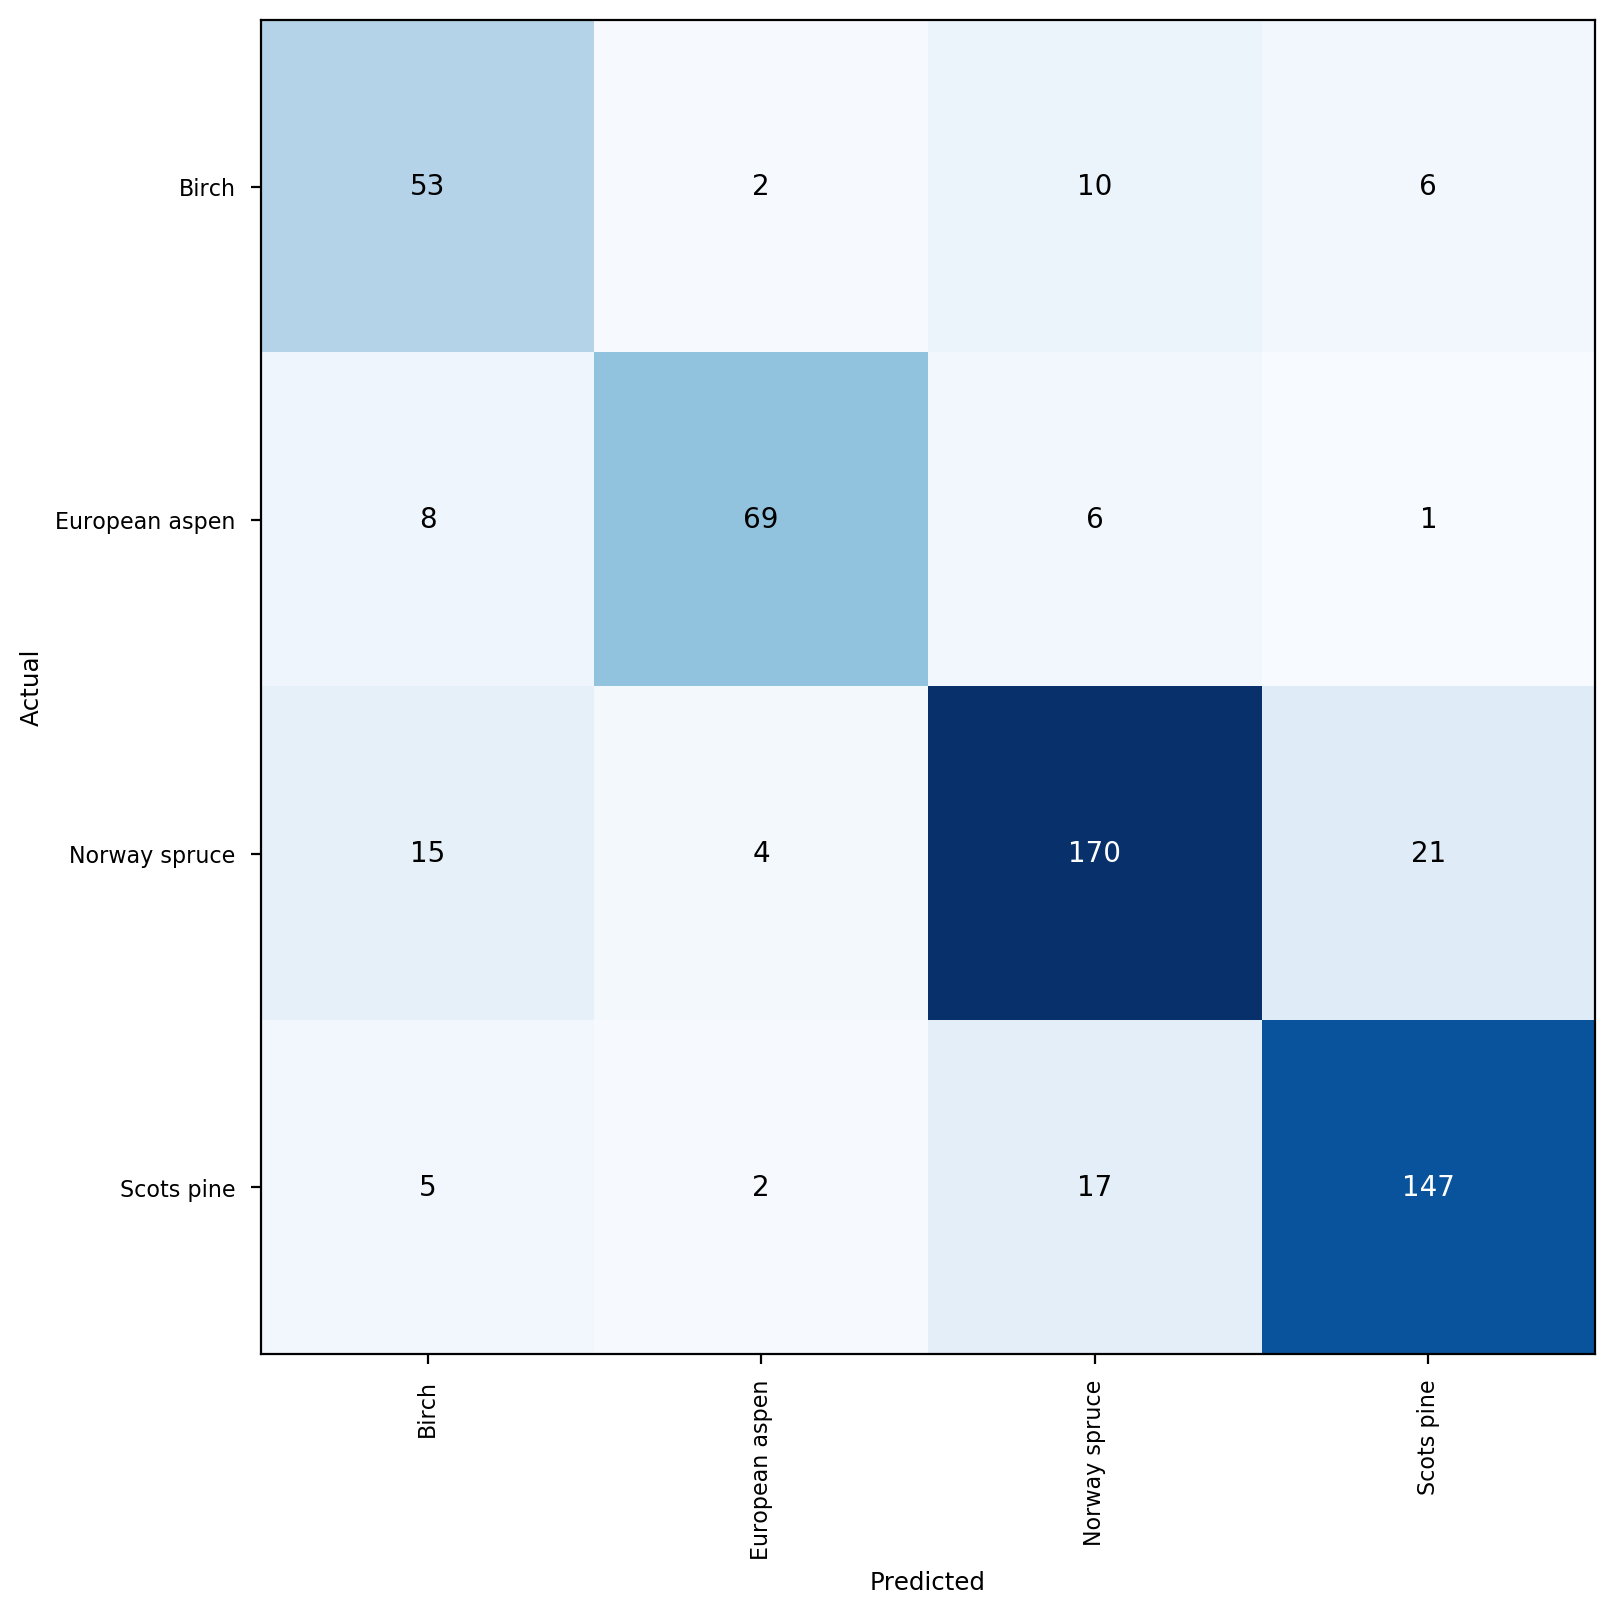

In [206]:
interp.plot_confusion_matrix(dpi=200, plot_txt=True, title=None)

In [207]:
interp.print_classification_report()

                precision    recall  f1-score   support

         Birch       0.65      0.75      0.70        71
European aspen       0.90      0.82      0.86        84
 Norway spruce       0.84      0.81      0.82       210
    Scots pine       0.84      0.86      0.85       171

      accuracy                           0.82       536
     macro avg       0.81      0.81      0.81       536
  weighted avg       0.82      0.82      0.82       536



# Make confusion matrix plots

In [208]:
def make_confusion_matrix(cm, ax, title, vocab):
    ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title(title)
    tick_marks = np.arange(len(vocab))
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(vocab)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(vocab)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        ax.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)
    return ax

In [209]:
from sklearn.metrics import confusion_matrix

In [210]:
ann_cmtx = interp.confusion_matrix()

In [211]:
lgb_cmtx = confusion_matrix(test_y, lgb_preds)

In [212]:
svm_cmtx = confusion_matrix(test_y, lin_svm_preds)
rf_cmtx = confusion_matrix(test_y, rf_preds)

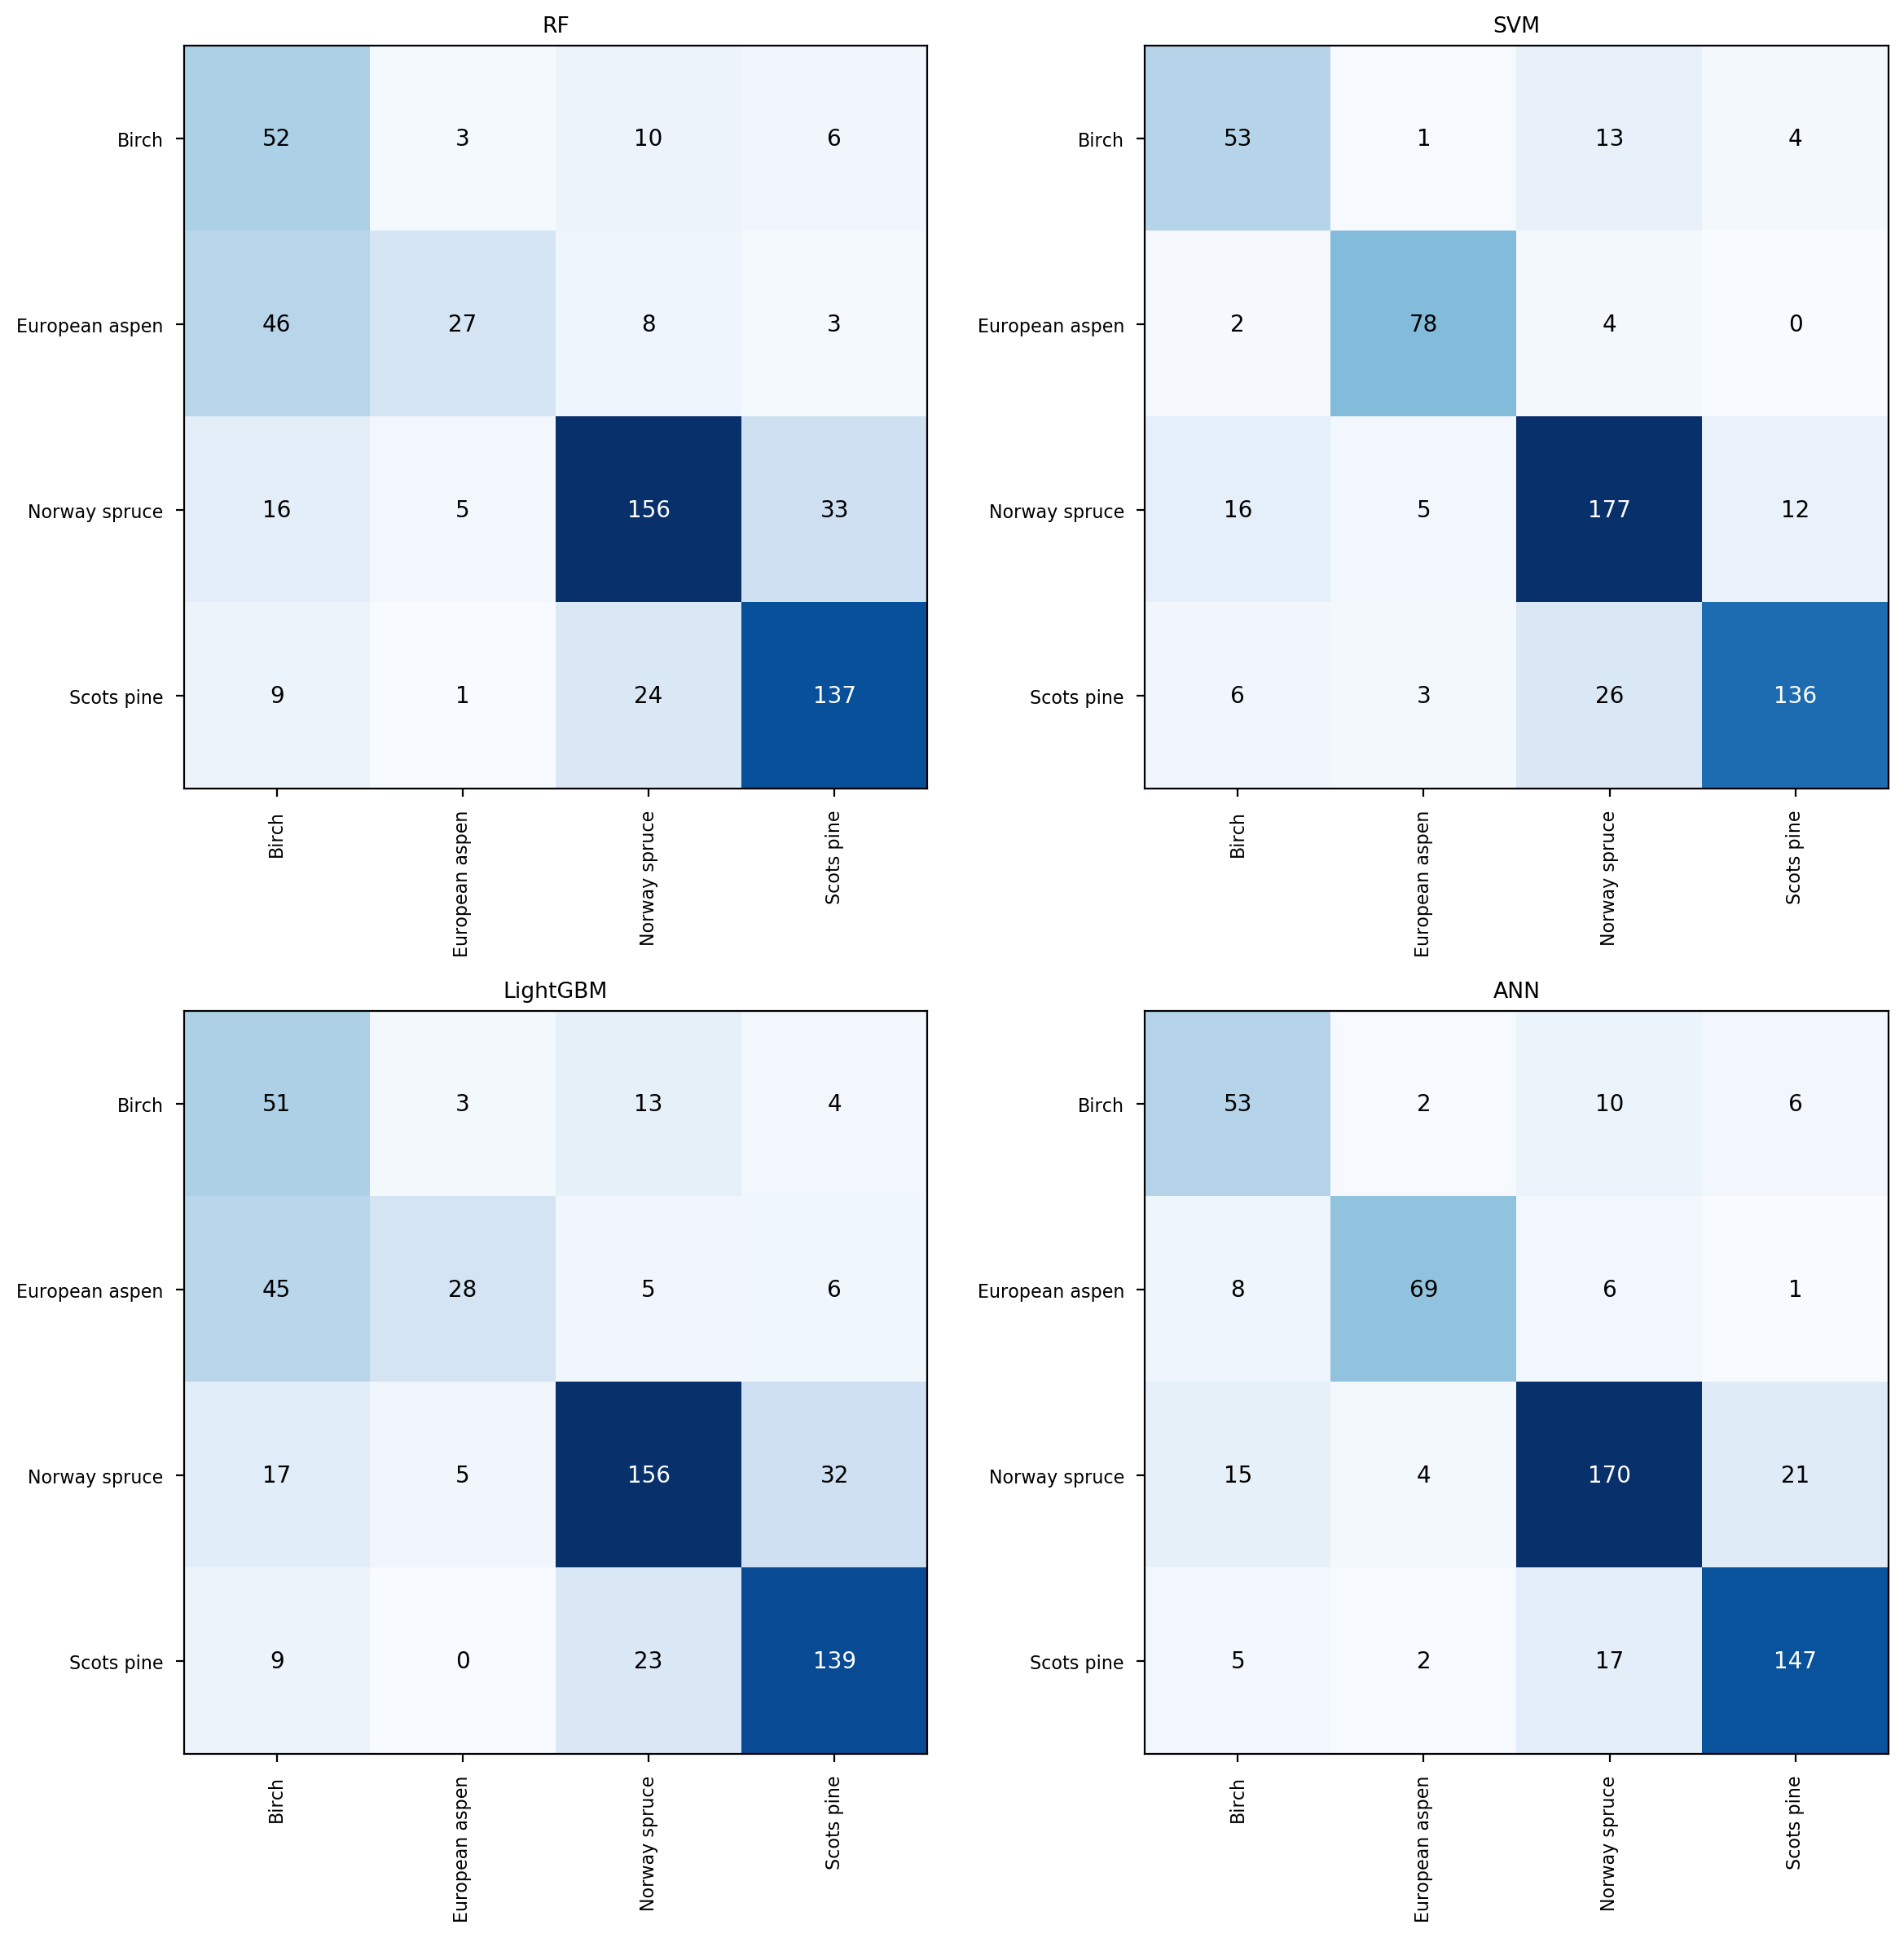

In [215]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
make_confusion_matrix(rf_cmtx, axs[0,0], title='RF', vocab=species)
make_confusion_matrix(svm_cmtx, axs[0,1], title='SVM', vocab=species)
make_confusion_matrix(lgb_cmtx, axs[1,0], title='LightGBM', vocab=species)
make_confusion_matrix(ann_cmtx, axs[1,1], title='ANN', vocab=species)
plt.tight_layout()
plt.savefig('cmtx.jpeg', dpi=300, bbox_inches='tight')